## *Using neural networks to estimate Young's Modulus for elements*

Packages 
<ul>
    <li>Pymatgen</li>
    <li> Mendeleev</li>
    <li> SKlearn </li>
    <li> Matplotlib </li>
    </ul>
    

In this lab we will learn how to use neural networks from the SKlearn library to create a regression model to estimate Young's modulus.

Agenda for this lab is 

1. Query online databases such as Pymatgen and Mendeleev to obtain element attributes and properties
2. Use SKLearn's nonlinear module for Neural network regression
3. Analyze the model performance by varying number of hidden units and hidden layers

### 1. Getting a dataset

In this section we will query both [Pymatgen](http://pymatgen.org/) and [Mendeleev](https://mendeleev.readthedocs.io/en/stable/) to get a complete set of properties per element. We will use this data to create the cases from which the model will train and test.
<br>
<br>
In this first snippet of code we will import all relevant libraries, the elements that will be turned into cases and the properties that will serve as the attributes for the cases. We will get 49 entries (which is a small dataset), but should give us a somewhat accurate prediction. We will also include some values to "patch" some unknown values in the dataset. It is important to note that more entries would move the prediction closer to the real value, and so would more attributes.
<br>
<br>
The elements listed were chosen because querying them for these properties yields a dataset with few unknown values, and because they represent the three most common crystallographic structures.

In [35]:
import pymatgen as pymat
import mendeleev as mendel
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [80]:
fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Cr", "Cs", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Rb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Ca", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Ru", "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn", "Zr"]
others = ["Si", "Ge"] # "Si" and "Ge" are Face-centered diamond-cubic;


# This is the list containing all the above elements
elements = fcc_elements + others + bcc_elements + hcp_elements

# Below is the list of features that we need to obtain from Mendeleev database
querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point",
                      "en_ghosh",  "evaporation_heat", "heat_of_formation",
                     "lattice_constant", "specific_heat"]

# Below is the list of features that we need to obtain from Pymaten database
querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity",
                     "molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid",
                     "coefficient_of_linear_thermal_expansion"]

#The list below includes all the properties
querable_values = querable_mendeleev + querable_pymatgen

After setting these values, we will proceed with our queries. Depending on the database (either Pymatgen or Mendeleev) where the property can be found, the code below fills up a list with the properties of each of the elements. To visualize how the dataset we just created looks, we will use the [Pandas](https://pandas.pydata.org/) library to display it. This library will take the list of lists and show it in a nice, user-friendly table with the properties as the column headers.

* <font color=blue> **Exercise 1.** Fill in the code snippet below to query Pymatgen and Mendeleev for the required properties.</font>

In [103]:
all_values = [] # Values for Attributes
all_labels = [] # Values for Young's Modulus (Property to be estimated)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item) # Enter your code here
    #Ques - Write a for loop over querable_mendeleev and append the property value in element_values
    for i in querable_mendeleev:
        element_values.append(getattr(element_object, i))
    #df = df[querable_mendeleev]

    # This section queries Pymatgen
    element_object = pymat.Element(item) # Enter your code here
    #Ques - Write a for loop over querable_pymatgen and append the property value in element_values
    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object, i))
    
    all_values.append(element_values) # All lists are appended to another list, creating a list of lists
    

In [104]:
# Only run this cell once you are done with data query part in the cell above.
# This cell is for debugging purpose. 
assert(len(all_values) == len(elements)),"Len of all_values not equal to len of elements."

In [105]:
# This code replaces some missing values in the data. You don't need to fill anything here. Just run this cell before moving forward.
# Pandas Dataframe
import os
df = pd.DataFrame(all_values, columns=querable_values)

# We will patch some of the values that are not available in the datasets.

# Value for the CTE of Cesium
index_Cs = df.index[df['atomic_number'] == 55]
df.iloc[index_Cs, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000097 
# Value from: David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition. CRC Press. Boca Raton, Florida, 2003

# Value for the CTE of Rubidium
index_Rb = df.index[df['atomic_number'] == 37]
df.iloc[index_Rb, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000090 
# Value from: https://www.azom.com/article.aspx?ArticleID=1834

# Value for the Evaporation Heat of Ruthenium
index_Ru = df.index[df['atomic_number'] == 44]
df.iloc[index_Ru, df.columns.get_loc("evaporation_heat")] = 595 # kJ/mol 
# Value from: https://www.webelements.com/ruthenium/thermochemistry.html

# Value for the Bulk Modulus of Zirconium
index_Zr = df.index[df['atomic_number'] == 40]
df.iloc[index_Zr, df.columns.get_loc("bulk_modulus")] = 94 # GPa 
# Value from: https://materialsproject.org/materials/mp-131/

# Value for the Bulk Modulus of Germanium
index_Ge = df.index[df['atomic_number'] == 32]
df.iloc[index_Ge, df.columns.get_loc("bulk_modulus")] = 77.2 # GPa 
# Value from: https://www.crystran.co.uk/optical-materials/germanium-ge

# Value for the Young's Modulus of Germanium
index_Ge = df.index[df['atomic_number'] == 32]
df.iloc[index_Ge, df.columns.get_loc("youngs_modulus")] = 102.7 # GPa 
# Value from: https://www.crystran.co.uk/optical-materials/germanium-ge


In [110]:
# The labels (values for Young's modulus) are stored separately for clarity (We drop the column later)

all_labels = df['youngs_modulus'].tolist()
df = df.drop(['youngs_modulus'], axis=1)

df.head(n=10) # With this line you can see the first ten entries of our database

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,lattice_constant,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,47,10.30,2485.0,0.147217,254.1,284.9,4.09,0.237,107.868200,1.60,1.630000e-08,10.27,100.0,1.086667,10490.0,0.000019
1,13,10.00,2740.0,0.150078,284.1,330.9,4.05,0.900,26.981539,1.25,2.700000e-08,10.00,76.0,0.675000,2700.0,0.000023
2,79,10.20,3080.0,0.261370,340.0,368.2,4.08,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,1.070000,19300.0,0.000014
3,29,7.10,2840.0,0.151172,304.6,337.4,3.61,0.385,63.546000,1.35,1.720000e-08,7.11,140.0,0.820000,8920.0,0.000017
4,77,8.54,4403.0,0.251060,604.0,669.0,3.84,0.133,192.217000,1.35,4.700000e-08,8.52,320.0,0.765000,22650.0,0.000006
5,28,6.60,3005.0,0.147207,378.6,430.1,3.52,0.443,58.693400,1.35,7.200000e-08,6.59,180.0,0.740000,8908.0,0.000013
6,82,18.30,2013.0,0.177911,177.8,195.2,4.95,0.159,207.200000,1.80,2.100000e-07,18.26,46.0,1.122500,11340.0,0.000029
7,46,8.90,3413.0,0.144028,372.4,376.6,3.89,0.244,106.420000,1.40,1.080000e-07,8.56,180.0,0.846250,12023.0,0.000012
8,78,9.10,4100.0,0.256910,470.0,565.7,3.92,0.133,195.084000,1.35,1.060000e-07,9.09,230.0,0.805000,21090.0,0.000009
9,45,8.30,4000.0,0.140838,494.0,556.0,3.80,0.244,102.905500,1.35,4.300000e-08,8.28,380.0,0.745000,12450.0,0.000008


* <font color=blue> **Exercise 2.** Use the Pandas dataframe created above to plot Young's modulus vs lattice constant. Note that this is recreating the plot from previous tutorials, but using the Pandas framework to slice and access data </font>

Text(0, 0.5, 'Youngs Modulus')

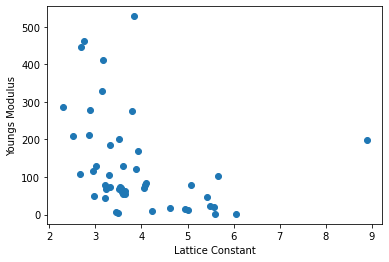

In [111]:
# Enter your code here

# prep data
x = df.lattice_constant.values
y = all_labels


fig, ax = plt.subplots(1,1)

ax = plt.scatter(x, y)

plt.xlabel('Lattice Constant')
plt.ylabel('Youngs Modulus')

### 2. Processing and Organizing Data

Most machine learning models are trained on a subset of all the available data, called the "training set", and the models are tested on the remainder of the available data, called the "testing set". Model performance has often been found to be enhanced when the inputs are normalized.

##### SETS

With the dataset we just created, we have 49 entries for our model. We will train with 44 cases and test on the remaining 5 elements to estimate Young's Modulus.

##### NORMALIZATION

Each one of these input data features has different units and is represented in scales with distinct orders of magnitude. Datasets that contain inputs like this need to be normalized, so that quantities with large values do not *overwhelm* the neural network, forcing it tune its weights to account for the different scales of our input data. In this tutorial, we will use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.

<span style="font-size:2em;">$ \frac{X - µ}{σ} $ </span>

While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

* <font color=blue> **Exercise 3.** Perform normalization on the input features stored in the dataframe df </font>

In [114]:
meanX = df.values.mean(axis = 0)
stdX =  df.values.std(axis = 0)
normX =  (df.values - meanX) / stdX

#check work
print(normX.mean(axis = 0))
print(normX.var(axis = 0))

[ 7.25043608e-17 -1.35945676e-17 -3.17206578e-17  2.99080488e-16
 -2.31107650e-16  2.12981560e-16  3.17206578e-16  5.66440319e-17
  6.91057189e-17  6.55371449e-16 -2.77555756e-17  6.96721592e-17
 -1.61435491e-16  1.57470409e-16  1.01959257e-17 -5.66440319e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


* <font color=blue> **Exercise 4.** Check if there is any Nan in the dataframe normX </font> 

Hint - you may want to check numpy' isnan( ) method. This returns boolean matrix, the sum of which can tell the total number of NaN's in your input dataframe

In [118]:
#count how many NaN (aka True aka 1 values are in the original dataframe)

np.count_nonzero(np.isnan(df.values))

0

##### Split data into training and test set

* <font color=blue> **Exercise 5.** Use SKLearn's train_test_split to obtain training and test set. Use 10% as test set </font> 

In [120]:
#Enter your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normX, all_labels, test_size = 0.2)

* <font color=blue> **Exercise 6.** Use SKLearn's neural network class to create a neural network with 20 hidden units and one layer. The default activation function is relu and we will use it for this part of the assignement. In the next part, we will change the activation function but for now lets keep everything except the number of hidden units at default values. </font> 

In [125]:
#import dependencies
from sklearn.neural_network import MLPRegressor

#define model

reg = MLPRegressor(hidden_layer_sizes= (20, ), activation= 'relu')


* <font color=blue> **Exercise 7.** Fit the above neural network on the training set. </font> 

In [126]:
#Enter your code here

reg.fit(X_train, y_train)

C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20, 1), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

* <font color=blue> **Exercise 8.** Use the fitted model to predict on training set and compute mean absolute error . </font> 

In [130]:
#load dependencies
from sklearn.metrics import mean_absolute_error

#get train predictions
y_train_prediction = reg.predict(X_train)

print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))


the mean absolute error is 123.94


* <font color=blue> **Exercise 9.** Use the fitted model to predict on test set and compute mean absolute error . </font> 

In [131]:
#load dependencies
from sklearn.metrics import mean_absolute_error

#get train predictions
y_test_prediction = reg.predict(X_test)

print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))


the mean absolute error for testing data is 138.27


* <font color=blue> **Exercise 10.** In this part we will increase the number of hidden units to 100 and compare the performance to previous model. Fit a neural network with 100 hidden units to the above training data. Compute mean absolute error on both training and test set. Comment on your findings i.e. how MAE changed on increasing number of hidden units. </font> 

In [133]:
#define model

reg = MLPRegressor(hidden_layer_sizes= (100, ), \
                   activation= 'relu').fit(X_train, y_train)
#get train predictions
y_train_prediction = reg.predict(X_train)

print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))

#get train predictions
y_test_prediction = reg.predict(X_test)

print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))


the mean absolute error for training data is 103.47
the mean absolute error for testing data is 115.23


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


* <font color=blue> **Exercise 11.** In the last part, we had a single layer of hidden units. In this part we will add an additional hidden layers of 100 units and compare the performance to previous model. Fit a neural network with 2 layers each with 100 hidden units to the above training data. Compute mean absolute error on both training and test set. Comment on your findings i.e. how MAE changed on increasing number of hidden layers. </font>

In [152]:
#define model

reg = MLPRegressor(hidden_layer_sizes= (100, 100), \
                   activation= 'relu').fit(X_train, y_train)
#get train predictions
y_train_prediction = reg.predict(X_train)

print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))

#get train predictions
y_test_prediction = reg.predict(X_test)

print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))


the mean absolute error for training data is 42.32
the mean absolute error for testing data is 47.51


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Comments on the above question

Both the training and test error are lower with addition of more neurons and an extra layer. Increasing the number of neurons by 5 has a smaller affect on the MAE compared to adding extra layers. On the basis of inspection, increasing model complexity through extra layers improves its fit most rapidly

* <font color=blue> **Exercise 12.** So far, we have been working with Relu activation function. In this part we will change the activation function to be tanh and compare the performance to previous model. Fit a neural network with 2 layers each with 100 hidden units to the above training data, with tanh as activation function. Compute mean absolute error on both training and test set. Comment on your findings i.e. how MAE changed with activation function. </font>

In [153]:
#define model

reg = MLPRegressor(hidden_layer_sizes= (100, 100), \
                   activation= 'tanh').fit(X_train, y_train)
#get train predictions
y_train_prediction = reg.predict(X_train)

print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))

#get train predictions
y_test_prediction = reg.predict(X_test)

print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))



the mean absolute error for training data is 101.19
the mean absolute error for testing data is 111.38


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### comment

The 'rehu' function only activates the neuron if the value is greater than 0, so it is deactivating the features for all values less than the mean - giving a less complex data set to fit. Conversely, the hyperbolic tanget function does not deactivate any neurons completely, meaning the model has to fit all data values, giving an increased error

* <font color=blue> **Exercise 13.** A very important parameter during neural network training or for any optimization problem is the learning rate and maximum number of iterations. Sometimes, we get poor performance due to non-optimal setting of these hyperparameters. In this part of the lab, use the same neural network architecture as last cell. Change the maximum number of iterations to 1000 (default is 200). Fit a neural network with 2 layers each with 100 hidden units to the above training data, with tanh as activation function. Compute mean absolute error on both training and test set. Comment on your findings i.e. how MAE changed with maximum iterations. </font>

In [151]:
#define model

reg = MLPRegressor(hidden_layer_sizes= (100, 100), \
                   activation= 'tanh', \
                  max_iter = 1000).fit(X_train, y_train)
#get train predictions
y_train_prediction = reg.predict(X_train)

print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))

#get train predictions
y_test_prediction = reg.predict(X_test)

print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))



the mean absolute error for training data is 59.25
the mean absolute error for testing data is 76.63


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### comment

Increasing the max number of itterations gives the model more opportunities to fit the data, likely improving the fit. This is seen in the lower MAE values compared to the equivalent model with only 200 itterations. The cost of this is computational time, but in this case it is negligable given the small data set.

* <font color=blue> **Exercise 14.** We used SKLearn 's neural network class to fit five different neural networks. In this part, go through the documentation and change different parameters and report the lowest MAE on test set you achieved on this dataset. You can also monitor n_iter_ output of the neural network and see which optimization algorithm resulted in lowest number of iterations.</font>

In [154]:
activation_funcs = ['identity', 'logistic', 'tanh', 'relu']
learning_rates = ['constant', 'invscaling', 'adaptive']
max_iters = [100, 1000, 10000]

for funcs in activation_funcs:
    for rates in learning_rates:
        for n in max_iters:

            #define model
            reg = MLPRegressor(hidden_layer_sizes= (100, 100), \
                               activation= funcs, \
                              max_iter = n, \
                              learning_rate= rates).fit(X_train, y_train)
            #get train predictions
            y_train_prediction = reg.predict(X_train)
            y_test_prediction = reg.predict(X_test)

            print(funcs, rates, n)
            
            print('the mean absolute error for training data is %0.2f' % mean_absolute_error(y_train, y_train_prediction))
            #get train predictions
            print('the mean absolute error for testing data is %0.2f' % mean_absolute_error(y_test, y_test_prediction))


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


identity constant 100
the mean absolute error for training data is 92.89
the mean absolute error for testing data is 84.27


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


identity constant 1000
the mean absolute error for training data is 46.52
the mean absolute error for testing data is 46.50
identity constant 10000
the mean absolute error for training data is 46.02
the mean absolute error for testing data is 50.00
identity invscaling 100
the mean absolute error for training data is 91.85
the mean absolute error for testing data is 81.97


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


identity invscaling 1000
the mean absolute error for training data is 46.87
the mean absolute error for testing data is 45.03
identity invscaling 10000
the mean absolute error for training data is 46.05
the mean absolute error for testing data is 49.89
identity adaptive 100
the mean absolute error for training data is 90.78
the mean absolute error for testing data is 82.92


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


identity adaptive 1000
the mean absolute error for training data is 46.80
the mean absolute error for testing data is 45.07
identity adaptive 10000
the mean absolute error for training data is 45.96
the mean absolute error for testing data is 50.04
logistic constant 100
the mean absolute error for training data is 116.98
the mean absolute error for testing data is 130.31


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic constant 1000
the mean absolute error for training data is 75.52
the mean absolute error for testing data is 81.80


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic constant 10000
the mean absolute error for training data is 4.09
the mean absolute error for testing data is 40.63
logistic invscaling 100
the mean absolute error for training data is 117.26
the mean absolute error for testing data is 130.65


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic invscaling 1000
the mean absolute error for training data is 77.18
the mean absolute error for testing data is 81.82


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic invscaling 10000
the mean absolute error for training data is 19.09
the mean absolute error for testing data is 51.81
logistic adaptive 100
the mean absolute error for training data is 115.65
the mean absolute error for testing data is 128.63


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adaptive 1000
the mean absolute error for training data is 75.86
the mean absolute error for testing data is 81.71


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic adaptive 10000
the mean absolute error for training data is 6.69
the mean absolute error for testing data is 74.36
tanh constant 100
the mean absolute error for training data is 113.89
the mean absolute error for testing data is 124.72


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh constant 1000
the mean absolute error for training data is 59.12
the mean absolute error for testing data is 77.75


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh constant 10000
the mean absolute error for training data is 0.36
the mean absolute error for testing data is 39.76
tanh invscaling 100
the mean absolute error for training data is 113.22
the mean absolute error for testing data is 122.68


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh invscaling 1000
the mean absolute error for training data is 59.41
the mean absolute error for testing data is 77.35


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh invscaling 10000
the mean absolute error for training data is 0.37
the mean absolute error for testing data is 49.72
tanh adaptive 100
the mean absolute error for training data is 114.26
the mean absolute error for testing data is 125.09


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adaptive 1000
the mean absolute error for training data is 59.19
the mean absolute error for testing data is 76.81


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh adaptive 10000
the mean absolute error for training data is 0.82
the mean absolute error for testing data is 64.21
relu constant 100
the mean absolute error for training data is 59.84
the mean absolute error for testing data is 57.03


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu constant 1000
the mean absolute error for training data is 10.34
the mean absolute error for testing data is 46.75
relu constant 10000
the mean absolute error for training data is 0.05
the mean absolute error for testing data is 32.89


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu invscaling 100
the mean absolute error for training data is 59.78
the mean absolute error for testing data is 55.87


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu invscaling 1000
the mean absolute error for training data is 10.66
the mean absolute error for testing data is 39.21
relu invscaling 10000
the mean absolute error for training data is 0.06
the mean absolute error for testing data is 54.77
relu adaptive 100
the mean absolute error for training data is 50.84
the mean absolute error for testing data is 48.58


C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ian Johnston\Anaconda3\envs\MSE1065\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu adaptive 1000
the mean absolute error for training data is 13.62
the mean absolute error for testing data is 42.86
relu adaptive 10000
the mean absolute error for training data is 0.06
the mean absolute error for testing data is 57.63
